!pip install git+https://github.com/EEA-sensors/parallel-non-linear-gaussian-smoothers.git@master

If running on Colab please run the command above.

### Imports

In [2]:
import jax.numpy as jnp
from jax import jit

from jax.config import config

from parsmooth.parallel import ckf, cks, icks
from parsmooth.sequential import ckf as seq_ckf, cks as seq_cks, icks as seq_icks
from parsmooth.models.bearings import get_data, make_parameters, plot_bearings
from parsmooth.utils import MVNormalParameters

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

### Input parameters

In [3]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

/u/95/corenfa1/unix/PycharmProjects/parallelEKF/venv/lib/python3.7/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


### Get parameters

In [4]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [5]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [6]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [7]:
initial_states = MVNormalParameters(jnp.zeros((T, 5)), jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))

In [8]:
vec_transition_function = jnp.vectorize(transition_function, signature="(m)->(m)")
vec_observation_function = jnp.vectorize(observation_function, signature="(m)->(d)")

In [9]:
filtered = ckf(initial_guess, 
               observations, 
               vec_transition_function, 
               Q, 
               vec_observation_function, 
               R, 
               initial_states)

In [10]:
smoothed = cks(vec_transition_function, Q, filtered)

### And the iterated one

In [12]:
iterated_smoothed_trajectories = icks(initial_guess, 
                                      observations, 
                                      vec_transition_function, 
                                      Q, 
                                      vec_observation_function, 
                                      R, 
                                      initial_states, 
                                      n_iter=100)

### For comparison we can run the sequential iterated smoother too

In [13]:
seq_iterated_smoothed_trajectories = seq_icks(initial_guess, 
                                              observations, 
                                              vec_transition_function, 
                                              Q, 
                                              vec_observation_function, 
                                              R, 
                                              initial_states, 
                                              n_iter=100)

### Plot the result

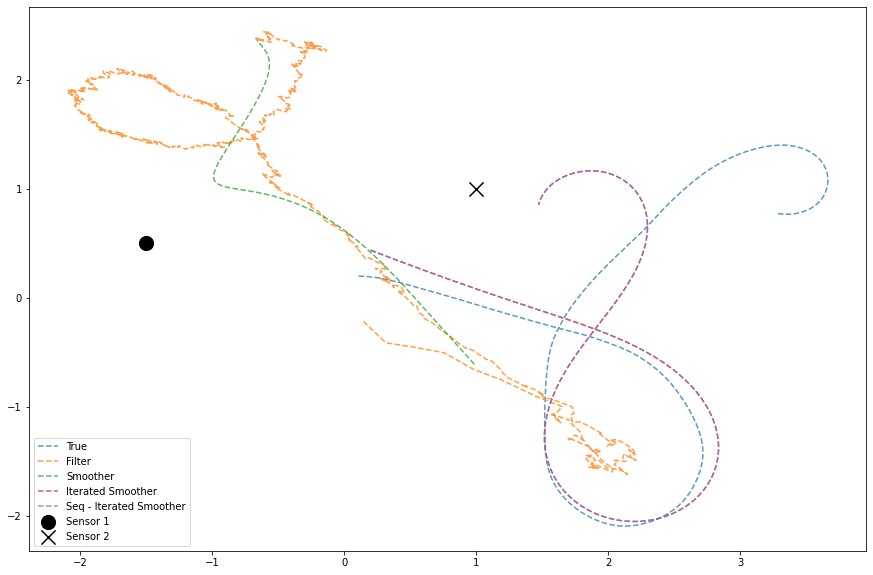

In [15]:
plot_bearings([true_states, filtered.mean, smoothed.mean, iterated_smoothed_trajectories.mean, seq_iterated_smoothed_trajectories.mean], 
              ["True", "Filter", "Smoother", "Iterated Smoother", "Seq - Iterated Smoother"], 
              s1, s2, figsize=(15, 10), quiver=False)